<a href="https://colab.research.google.com/github/dravitch/alloys/blob/main/tjc_tpv_btc_paxg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 📘 TJC × TPV : Visualisation Vivante BTC / PAXG

Ce notebook permet d'explorer la **fusion entre la Théorie des Jeux Complexes (TJC)** et la **Théorie des Portefeuilles Vivants (TPV)** à travers la paire `BTC-USD` / `PAXG-USD`.

- 🎯 Objectif : Visualiser les **phases, la cohérence, la dissonance** et le **potentiel d’émergence**
- 📡 Mesures : Cohérence de phase, Sharpe ratio, drawdown
- 🌐 Espace complexe : Représentation des trajectoires dans ℂ


In [1]:
!pip install yfinance numpy pandas matplotlib

In [2]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")


In [5]:

class YahooFinanceDataHandler:
    @staticmethod
    def standardize_yahoo_data(data):
        if isinstance(data.columns, pd.MultiIndex):
            data = pd.DataFrame({
                'open': data['Open'].iloc[:, 0],
                'high': data['High'].iloc[:, 0],
                'low': data['Low'].iloc[:, 0],
                'close': data['Close'].iloc[:, 0],
                'volume': data['Volume'].iloc[:, 0]
            })
        else:
            data.columns = data.columns.str.lower()
        return data

    @staticmethod
    def validate_yahoo_data(df):
        required_columns = ['open', 'high', 'low', 'close', 'volume']
        missing = set(required_columns) - set(df.columns)
        if missing:
            raise ValueError(f"Colonnes manquantes: {missing}")
        if df.empty:
            raise ValueError("DataFrame vide")
        return True

    @staticmethod
    def fetch_with_retry(symbol, start_date, end_date, retries=3, delay=1):
        for attempt in range(retries):
            try:
                df = yf.download(symbol, start=start_date, end=end_date, progress=False)
                if df.empty:
                    raise ValueError(f"Aucune donnée disponible pour {symbol}")
                df = YahooFinanceDataHandler.standardize_yahoo_data(df)
                YahooFinanceDataHandler.validate_yahoo_data(df)
                return df
            except Exception as e:
                if attempt == retries - 1:
                    raise
                print(f"Tentative {attempt + 1} échouée pour {symbol}. Réessai dans {delay} sec...")
                time.sleep(delay)
                delay *= 2

    @staticmethod
    def safe_fetch_pair(symbol1, symbol2, start_date, end_date):
        try:
            start_dt = pd.to_datetime(start_date)
            end_dt = pd.to_datetime(end_date)
            if start_dt >= end_dt:
                raise ValueError("La date de fin doit être après la date de début")
            df1 = YahooFinanceDataHandler.fetch_with_retry(symbol1, start_dt, end_dt)
            df2 = YahooFinanceDataHandler.fetch_with_retry(symbol2, start_dt, end_dt)
            common_index = df1.index.intersection(df2.index)
            if len(common_index) < 5:
                raise ValueError("Données insuffisantes après synchronisation")
            return df1.loc[common_index], df2.loc[common_index]
        except Exception as e:
            print(f"Erreur critique: {str(e)}")
            print(f"Paramètres: {symbol1}/{symbol2} de {start_date} à {end_date}")
            return None, None

In [7]:
# Import the necessary classes and functions from previous cells
# Assurez-vous que la classe YahooFinanceDataHandler et les fonctions associées
# sont définies dans les cellules précédentes ou dans ce fichier.
# Pour que cela fonctionne dans un notebook, elles doivent avoir été exécutées.
# Si elles sont dans un autre script, importez-les:
# from your_data_handler_script import YahooFinanceDataHandler
from datetime import datetime, timedelta # Assurez-vous que datetime et timedelta sont importés

warnings.filterwarnings('ignore')

# Placeholder function that will use YahooFinanceDataHandler
# Renommer pour éviter la confusion avec un nom générique 'fetch_data'
def fetch_pair_data_for_scan(symbol1, symbol2, start_date, end_date):
    """Fetches and prepares data for resonance scan using YahooFinanceDataHandler."""
    df1, df2 = YahooFinanceDataHandler.safe_fetch_pair(symbol1, symbol2, start_date, end_date)
    if df1 is not None and df2 is not None:
        # Calculate log returns
        df = pd.DataFrame({
            'r1': np.log(df1['close'] / df1['close'].shift(1)),
            'r2': np.log(df2['close'] / df2['close'].shift(1))
        }).dropna()
        return df
    return None # Return None if fetching failed or data insufficient


df = fetch_pair_data_for_scan("BTC-USD", "PAXG-USD", start_date='2024-03-01', end_date='2025-05-01')

# Check if df is None in case of critical error
if df is None:
    print("Failed to fetch data for BTC-USD and PAXG-USD.")
else:
    print("Data fetched successfully.")
    print(df.tail()) # Print tail only if df is not None


Data fetched successfully.
                  r1        r2
Date                          
2025-04-26 -0.000777  0.000531
2025-04-27 -0.009470 -0.002450
2025-04-28  0.012970  0.009809
2025-04-29 -0.007333 -0.007284
2025-04-30 -0.000822 -0.009893


In [8]:

theta = df['r1'] - df['r2']
df['phase_diff'] = theta
df['coherence'] = np.cos(theta)**2
df['dissonance'] = np.abs(np.sin(theta))


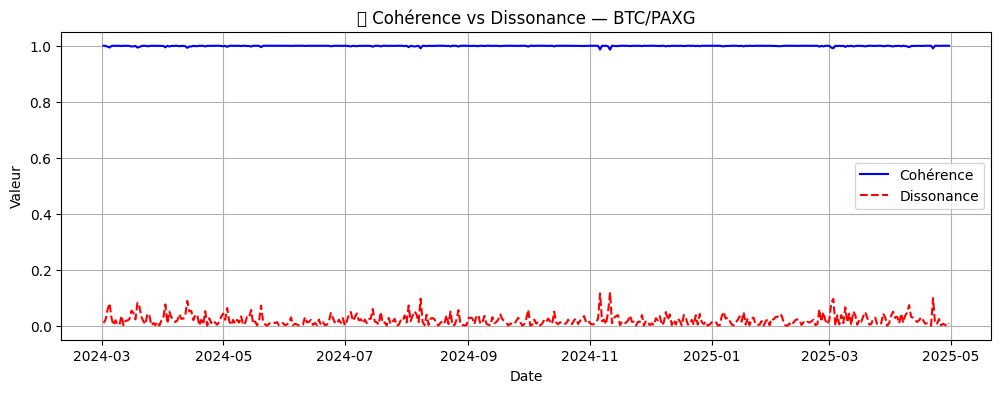

In [9]:

plt.figure(figsize=(12, 4))
plt.plot(df.index, df['coherence'], label="Cohérence", color='blue')
plt.plot(df.index, df['dissonance'], label="Dissonance", color='red', linestyle='--')
plt.title("🌀 Cohérence vs Dissonance — BTC/PAXG")
plt.xlabel("Date")
plt.ylabel("Valeur")
plt.legend()
plt.grid(True)
plt.show()


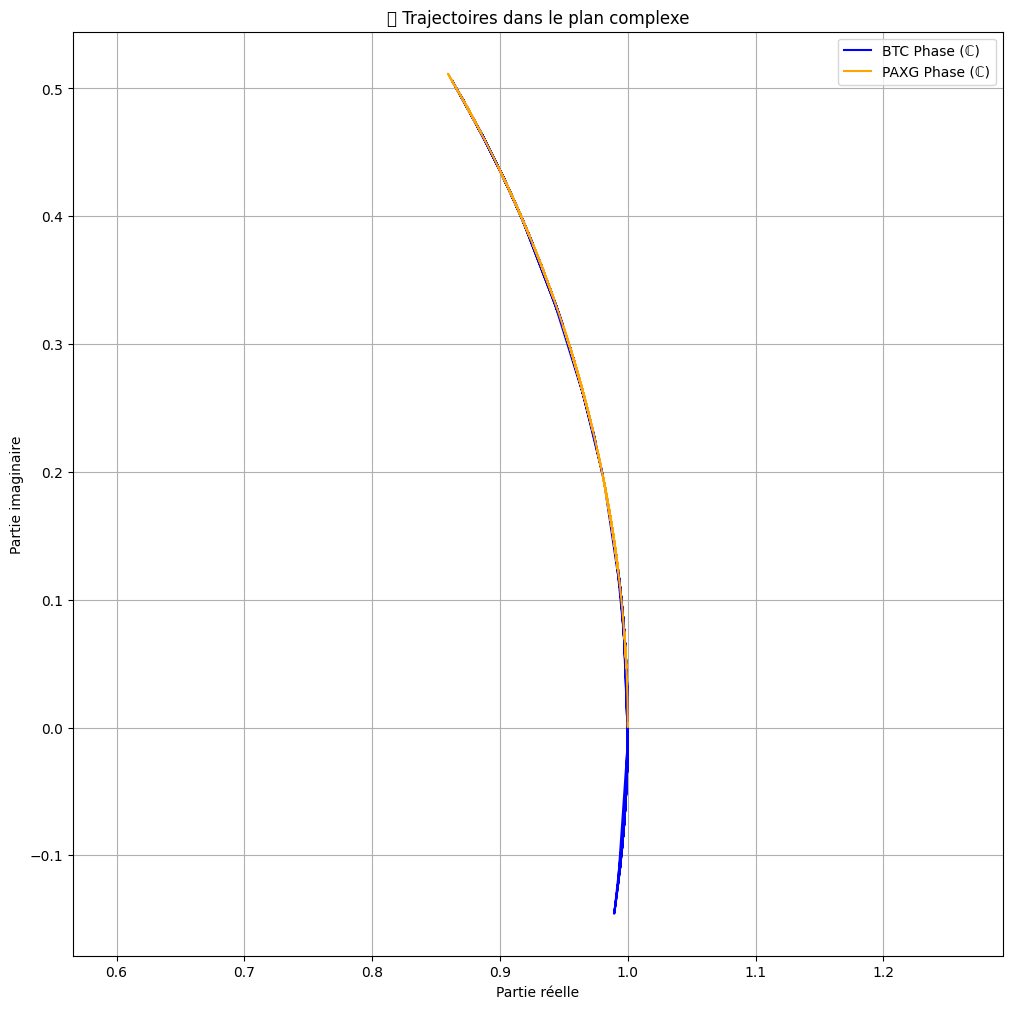

In [12]:
theta1 = df['r1'].cumsum()
theta2 = df['r2'].cumsum()
z1 = np.exp(1j * theta1)
z2 = np.exp(1j * theta2)

plt.figure(figsize=(12, 12))
# Access the underlying numpy array using .values to get real and imaginary parts
plt.plot(z1.values.real, z1.values.imag, label='BTC Phase (ℂ)', color='blue')
plt.plot(z2.values.real, z2.values.imag, label='PAXG Phase (ℂ)', color='orange')
plt.title("🌐 Trajectoires dans le plan complexe")
plt.xlabel("Partie réelle")
plt.ylabel("Partie imaginaire")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [13]:

r_mix = 0.5 * df['r1'] + 0.5 * df['r2']
sharpe = r_mix.mean() / r_mix.std() * np.sqrt(252)
drawdown = (100 * (1 + r_mix).cumprod() / (100 * (1 + r_mix).cumprod()).cummax() - 1).min()
coherence_avg = df['coherence'].mean()

print(f"Cohérence moyenne: {coherence_avg:.4f}")
print(f"Sharpe ratio mixé BTC/PAXG: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2%}")


Cohérence moyenne: 0.9992
Sharpe ratio mixé BTC/PAXG: 1.10
Max Drawdown: -13.97%



---

## 📖 Interprétation

- La **cohérence** révèle les zones où BTC et PAXG dansent "en phase"
- La **dissonance** alerte sur les tensions ou ruptures
- L’**espace complexe** montre l’harmonie ou les divergences géométriques
- Ces éléments sont des **signaux précoces de transformation**

> Le portefeuille vivant n’agit pas par force, mais par écoute.  
> Il n’attend pas le rendement, mais **reconnaît la forme qui appelle à l'action**.

